### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import datetime

In [2]:
df = pd.read_csv('data/Final_merged_dataset_clean.csv')

In [3]:
df.head(5)

id  home_team_api_id  away_team_api_id  crossing_h  finishing_h  \
0  1729             10260             10261        81.0         72.0   
1  1730              9825              8659        77.0         80.0   
2  1731              8472              8650        79.0         66.0   
3  1732              8654              8528        81.0         71.0   
4  1734              8668              8655        74.0         80.0   

   heading_accuracy_h  short_passing_h  volleys_h  dribbling_h  curve_h  ...  \
0                81.0             81.0       79.0         79.0     79.0  ...   
1                90.0             88.0       79.0         79.0     80.0  ...   
2                78.0             82.0       69.0         80.0     78.0  ...   
3                77.0             87.0       69.0         81.0     80.0  ...   
4                74.0             83.0       77.0         80.0     78.0  ...   

   defenceAggression_h  defenceTeamWidth_h  buildUpPlaySpeed_a  \
0            48.000000           54.833333           58.166667   
1            46.500000           50.500000           57.500000   
2            52.166667           51.833333           57.666667   
3            42.833333           40.166667           47.166667   
4            57.500000           56.333333           52.500000   

   buildUpPlayPassing_a  chanceCreationPassing_a  chanceCreationCrossing_a  \
0             55.333333                53.500000                 57.333333   
1             51.500000                53.000000                 56.000000   
2             44.333333                41.333333                 47.833333   
3             50.666667                52.666667                 55.500000   
4             63.833333                57.000000                 56.000000   

   chanceCreationShooting_a  defencePressure_a  defenceAggression_a  \
0                 49.833333          46.666667            48.333333   
1                 54.666667          43.000000            45.666667   
2                 57.333333          51.000000            52.500000   
3                 45.500000          50.000000            54.000000   
4                 42.000000          45.666667            55.000000   

   defenceTeamWidth_a  
0           48.333333  
1           54.833333  
2           56.000000  
3           46.000000  
4           46.666667  

[5 rows x 96 columns]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['match_winner', 'id', 'home_team_api_id', 'away_team_api_id', 'fouls_h', 'fouls_a']), 
                                                    df.match_winner, test_size=0.3, 
                                                    random_state=47)

In [5]:
X_train.shape, X_test.shape

((9307, 90), (3990, 90))

In [6]:
y_train.shape, y_test.shape

((9307,), (3990,))

In [7]:
train_mean = y_train.mean()
train_mean

1.8189534758783712

Draw most likely outcome, though this could be influence by even distribution of wins and losses for home teams

In [8]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[1.81895348]])

In [9]:
X_defaults_median = X_train.median()
X_train = X_train.fillna(X_defaults_median)
X_test = X_test.fillna(X_defaults_median)

# Create Initial Models

### Logistic Regression

In [10]:
LR_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(),
    LogisticRegression(),
)

In [11]:
LR_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest()),
                ('logisticregression', LogisticRegression())])

### KNeighborsClassifier

In [12]:
KNN_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(),
    KNeighborsClassifier(),
)

In [13]:
KNN_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest()),
                ('kneighborsclassifier', KNeighborsClassifier())])

### Random Forest

In [14]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(),
    RandomForestClassifier(),
)

In [15]:
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest()),
                ('randomforestclassifier', RandomForestClassifier())])

### Ridge Classifier

In [16]:
RC_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(),
    RidgeClassifier(),
)

In [17]:
RC_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest()),
                ('ridgeclassifier', RidgeClassifier())])

### Support Vectors

In [18]:
SVC_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(),
    SVC(),
)

In [19]:
SVC_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest()), ('svc', SVC())])

# Initial Model Metrics

In [20]:
pipes = [LR_pipe, KNN_pipe, RF_pipe, RC_pipe, SVC_pipe]

## Initial predicted Y Values per Model

In [21]:
print('Predicted Y values per initial model: \n')
for i, model in enumerate(pipes):
    print(model[3], ' :', np.unique(model.predict(X_test), return_counts=True))
print('\nActual Y Values in Test Set:\n\n', y_test.value_counts())

Predicted Y values per initial model: 

LogisticRegression()  : (array([1, 2, 3]), array([3206,    1,  783]))
KNeighborsClassifier()  : (array([1, 2, 3]), array([2608,  704,  678]))
RandomForestClassifier()  : (array([1, 2, 3]), array([2448,  589,  953]))
RidgeClassifier()  : (array([1, 2, 3]), array([3214,    1,  775]))
SVC()  : (array([1, 2, 3]), array([3469,    2,  519]))

Actual Y Values in Test Set:

 1    1819
3    1118
2    1053
Name: match_winner, dtype: int64


## Cross Validation

In [22]:
kfold = KFold(n_splits=10)

In [23]:
for i, model in enumerate(pipes):
    cv_results_a = cross_validate(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    #cv_results_p = cross_validate(model, X_train, y_train, cv=kfold, scoring='precision', n_jobs=-1)
    #cv_results_r = cross_validate(model, X_train, y_train, cv=kfold, scoring='recall', n_jobs=-1)
    print(model[3], 'score: ', model.score(X_test, y_test), 'accuracy: ', np.mean(cv_results_a['test_score']))
         #'precision: ', np.mean(cv_results_p['test_score']),
          #'recall: ', np.mean(cv_results_r['test_score'])
         #)
    
    #['test_accuracy'], cv_results['test_precision'], cv_results['test_recall'])

LogisticRegression() score:  0.474937343358396 accuracy:  0.4880232840164929
KNeighborsClassifier() score:  0.43734335839599 accuracy:  0.4406395019807584
RandomForestClassifier() score:  0.45964912280701753 accuracy:  0.46202245244447526
RidgeClassifier() score:  0.4756892230576441 accuracy:  0.4874863425845721
SVC() score:  0.47969924812030074 accuracy:  0.49081771248397493


#### It seems that at a scoring and accuracy of less tha 50%, the initial untuned models are not very good.

## Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix
pl_list = []
for i, model in enumerate(pipes):
    y_pred = model.predict(X_test)
    pl_list.append(confusion_matrix(y_test,y_pred))

In [25]:
class_names=['1', '2', '3'] # name  of classes

In [26]:
def plot_confusion_matrix(cm, classes ,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[1573    0  246]
 [ 836    1  216]
 [ 797    0  321]]
Confusion matrix, without normalization
[[1291  294  234]
 [ 689  187  177]
 [ 628  223  267]]
Confusion matrix, without normalization
[[1266  255  298]
 [ 642  162  249]
 [ 540  172  406]]
Confusion matrix, without normalization
[[1576    0  243]
 [ 841    1  211]
 [ 797    0  321]]
Confusion matrix, without normalization
[[1670    2  147]
 [ 925    0  128]
 [ 874    0  244]]


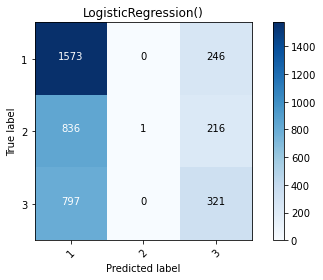

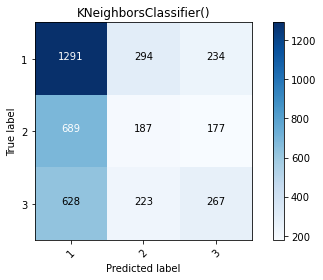

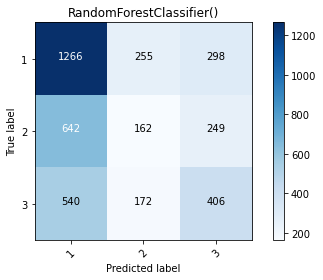

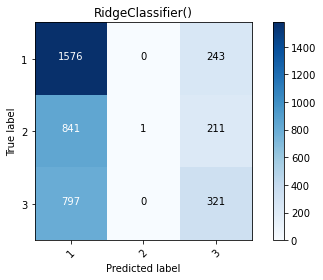

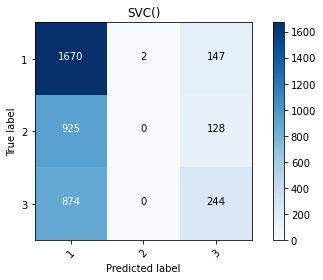

In [27]:
for i, model in enumerate(pipes):
    plot_confusion_matrix(pl_list[i], class_names, title=model[3])

# Hyperparameter Tuning

In [ ]:
for i, model in enumerate(pipes):
    print(model[3], model.get_params().keys(), '\n')

In [29]:
k = [k+1 for k in range(len(X_train.columns))]
#grid_params = {'selectkbest__k': k}

In [30]:
for i, model in enumerate(pipes):
    print(model[3])

LogisticRegression()
KNeighborsClassifier()
RandomForestClassifier()
RidgeClassifier()
SVC()


In [31]:
param_search = {}
#Logistic Regression
param_search[0] = {'selectkbest__k': k, 'logisticregression__max_iter' : [50, 100], 'logisticregression__n_jobs' :[-1]}
#KNN
param_search[1] = {'selectkbest__k': k, 'kneighborsclassifier__n_neighbors' : [1, 5, 10, 20, 50, 100],  
                   'kneighborsclassifier__leaf_size' : [5, 10, 20, 30, 50], 
                   'kneighborsclassifier__n_jobs' :[-1]}
#Random Forest
param_search[2] = {'selectkbest__k': k, 'randomforestclassifier__n_estimators' : [20, 50, 100],
                   'randomforestclassifier__criterion' : ['gini', 'entropy'],
                   'randomforestclassifier__max_depth' : ['None', 3, 4, 5],
                   'randomforestclassifier__max_leaf_nodes' : ['None', 3, 5, 7, 10, 20],
                   'randomforestclassifier__n_jobs' : [-1]}
#RidgeClassifier
param_search[3] = {'selectkbest__k': k}
#Support Vectors
param_search[4] = {'selectkbest__k': k}
tuned_results = []
tuned_best_score = []
tuned_best_estimator = []
#print(param_search)

In [32]:
for i, model in enumerate(pipes):
    #if name != 'LR':
    gsearch = GridSearchCV(estimator=model, param_grid = param_search[i], scoring = 'accuracy', n_jobs=-1)
    #if name != 'RFR':
    gsearch.fit(X_train, y_train)
    #else :
       # gsearch.fit(X_tr, y_train.values.ravel())
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    tuned_results.append(gsearch)
    tuned_best_score.append(best_score)
    tuned_best_estimator.append(best_model)
    print(best_model, best_score)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=44)),
                ('logisticregression',
                 LogisticRegression(max_iter=50, n_jobs=-1))]) 0.4928559019410813
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=9)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=5, n_jobs=-1,
                                      n_neighbors=100))]) 0.49435914188634245


/usr/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/mitch/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.48801956 0.48683815 0.48748233]
  warnings.warn(


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=4)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, max_leaf_nodes=20,
                                        n_estimators=20, n_jobs=-1))]) 0.4986564053489831
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=60)),
                ('ridgeclassifier', RidgeClassifier())]) 0.49382243126046477
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=42)), ('svc', SVC())]) 0.5056408003966314


The tuned model's metrics did not fare much better than untuned.

In [35]:
from sklearn.metrics import confusion_matrix
pl_list2 = []
for i, model in enumerate(tuned_best_estimator):
    y_pred2 = model.predict(X_test)
    pl_list2.append(confusion_matrix(y_test,y_pred2))

Confusion matrix, without normalization
[[1508   12  299]
 [ 820    9  224]
 [ 737    5  376]]
Confusion matrix, without normalization
[[1616   32  171]
 [ 893   18  142]
 [ 854   13  251]]
Confusion matrix, without normalization
[[1703    0  116]
 [ 938    0  115]
 [ 883    0  235]]
Confusion matrix, without normalization
[[1538   12  269]
 [ 830    8  215]
 [ 752    6  360]]
Confusion matrix, without normalization
[[1625    8  186]
 [ 853   10  190]
 [ 793   12  313]]


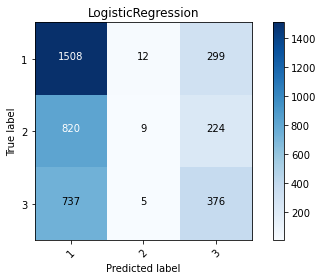

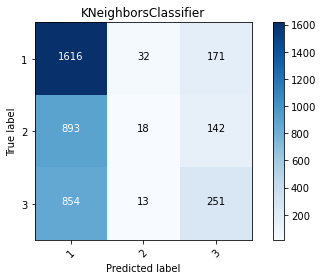

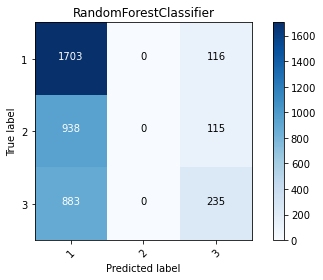

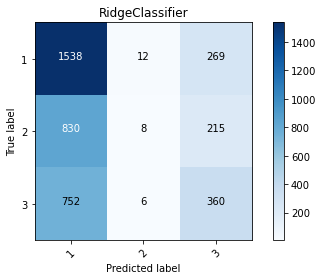

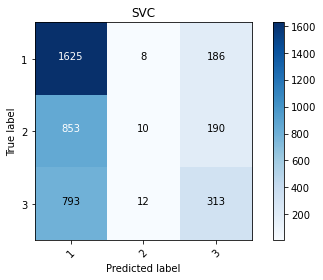

In [37]:
for i, model in enumerate(tuned_best_estimator):
    plot_confusion_matrix(pl_list2[i], class_names, title=type(model[3]).__name__)

# Feature Selection

## K best Score

In [54]:
tuned_best_estimator[0][2]

SelectKBest(k=44)

In [57]:
kbest_score = {}
for x, score in enumerate(tuned_best_estimator[0][2].scores_):
    kbest_score[X_train.columns.values[x]] = score
sorted_values = sorted(kbest_score.values(), reverse=True) # Sort the values
kbest_sorted = {}
for z in sorted_values:
    for k in kbest_score.keys():
        if kbest_score[k] == z:
            kbest_sorted[k] = kbest_score[k]
            break
kbest_sorted_df = pd.DataFrame.from_dict(kbest_sorted, orient='index')
kbest_sorted_df.head(44)

0
buildUpPlayPassing_h      81.907244
defencePressure_a         77.684631
buildUpPlayPassing_a      76.626319
defencePressure_h         68.157454
chanceCreationShooting_h  30.724597
interceptions_a           28.603195
chanceCreationShooting_a  28.168730
possession_h              15.194224
vision_h                  14.890572
interceptions_h           12.991135
away_strikers             11.235766
defenceAggression_a       11.136875
defenceTeamWidth_a        10.341126
heading_accuracy_a        10.294048
defenceAggression_h        9.895752
defenceTeamWidth_h         9.402923
positioning_a              8.885800
volleys_h                  8.234678
standing_tackle_h          8.216783
reactions_a                7.460395
aggression_a               7.396954
standing_tackle_a          7.123940
short_passing_a            6.808361
vision_a                   6.735743
aggression_h               6.029486
away_midfielders           5.764043
heading_accuracy_h         5.516692
marking_a                  5.495361
penalties_h                5.381116
jumping_h                  4.860277
penalties_a                4.625647
positioning_h              4.451277
short_passing_h            4.417183
shot_power_h               4.147799
chanceCreationPassing_h    4.116974
balance_a                  3.856073
chanceCreationCrossing_a   3.823431
strength_a                 3.263236
jumping_a                  3.170442
buildUpPlaySpeed_a         2.916541
home_strikers              2.829500
sliding_tackle_h           2.493516
buildUpPlaySpeed_h         2.184594
finishing_a                2.110804

In [58]:
print(list(kbest_sorted.keys())[:20])

['buildUpPlayPassing_h', 'defencePressure_a', 'buildUpPlayPassing_a', 'defencePressure_h', 'chanceCreationShooting_h', 'interceptions_a', 'chanceCreationShooting_a', 'possession_h', 'vision_h', 'interceptions_h', 'away_strikers', 'defenceAggression_a', 'defenceTeamWidth_a', 'heading_accuracy_a', 'defenceAggression_h', 'defenceTeamWidth_h', 'positioning_a', 'volleys_h', 'standing_tackle_h', 'reactions_a']


## Feature Importances Random Forest

In [64]:
feats = {}
for feature, importance in zip(X_train.columns, tuned_best_estimator[2][3].feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance')
importances.head(10)

Gini-importance
crossing_h                 0.303860
finishing_h                0.212192
heading_accuracy_h         0.259777
short_passing_h            0.224170

#### Repeat on untuned model

In [72]:
feats_u = {}
for feature, importance in zip(X_train.columns, RF_pipe[3].feature_importances_):
    feats_u[feature] = importance #add the name/value pair 
importances_u = pd.DataFrame.from_dict(feats_u, orient='index').rename(columns={0: 'Gini-importance'})
importances_u.sort_values(by='Gini-importance')
importances_u.head(10)

Gini-importance
crossing_h                   0.116692
finishing_h                  0.114039
heading_accuracy_h           0.109751
short_passing_h              0.109681
volleys_h                    0.097371
dribbling_h                  0.087779
curve_h                      0.090108
free_kick_accuracy_h         0.093849
long_passing_h               0.088596
ball_control_h               0.092134

Tuned and untuned model have the same top 4 important features

In [68]:
list(feats.keys())

['crossing_h', 'finishing_h', 'heading_accuracy_h', 'short_passing_h']

In [69]:
estimator = tuned_best_estimator[2][3].estimators_[4]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(feats.keys()),
                #class_names = X_train.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [85]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

<Figure size 1800x1200 with 0 Axes>

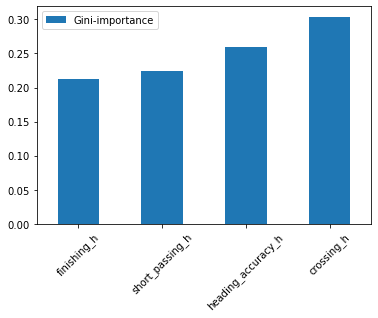

In [74]:
plt.figure(dpi=300)
plt.tight_layout()
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)
plt.savefig('featureimportances.jpg', dpi=200)

<Figure size 1800x1200 with 0 Axes>

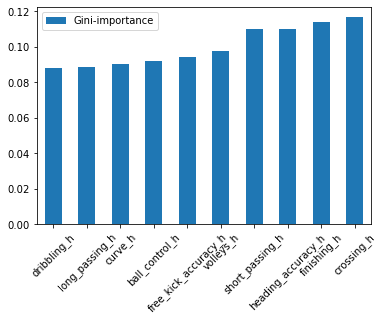

In [75]:
plt.figure(dpi=300)
plt.tight_layout()
importances_u.sort_values(by='Gini-importance').plot(kind='bar', rot=45)
plt.savefig('featureimportances.jpg', dpi=200)

In [146]:
pl_list.append(confusion_matrix(y2_test,y2_pred))

## Modify SVC to linear kernel to extract feature importances

In [94]:
SVC_lin_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(k=42),
    SVC(kernel='linear'),
)

In [95]:
SVC_lin_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=42)),
                ('svc', SVC(kernel='linear'))])

In [96]:
print(SVC_lin_pipe[2], ' :', np.unique(SVC_lin_pipe.predict(X_test), return_counts=True))
print('\nActual Y Values in Test Set:\n\n', y_test.value_counts())

SelectKBest(k=42)  : (array([1, 3]), array([3480,  510]))

Actual Y Values in Test Set:

 1    1819
3    1118
2    1053
Name: match_winner, dtype: int64


In [97]:
cv_results_svc = cross_validate(SVC_lin_pipe, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
print(model[3], 'score: ', SVC_lin_pipe.score(X_test, y_test), 'accuracy: ', np.mean(cv_results_svc['test_score']))

SVC() score:  0.48020050125313285 accuracy:  0.4903887599182287


performance is comparable to the tuned model which was 0.50 accurate

In [100]:
svc_k = SVC_lin_pipe[2].get_support(indices=True)
svc_k_cols = X_train.iloc[:,svc_k]

<AxesSubplot:>

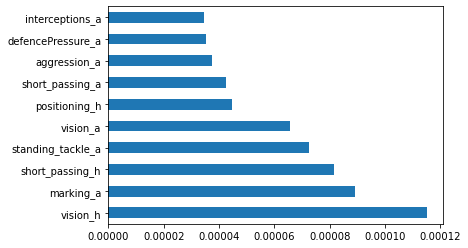

In [104]:
pd.Series(abs(SVC_lin_pipe[3].coef_[0]), index=svc_k_cols.columns).nlargest(10).plot(kind='barh')

# Final Model Metrics

In [129]:
importances.sort_values(by='Gini-importance',ascending=False)

Gini-importance
crossing_h                 0.303860
heading_accuracy_h         0.259777
short_passing_h            0.224170
finishing_h                0.212192

In [137]:
importances_u.sort_values(by='Gini-importance',ascending=False)

Gini-importance
crossing_h                   0.116692
finishing_h                  0.114039
heading_accuracy_h           0.109751
short_passing_h              0.109681
volleys_h                    0.097371
free_kick_accuracy_h         0.093849
ball_control_h               0.092134
curve_h                      0.090108
long_passing_h               0.088596
dribbling_h                  0.087779

In [131]:
pd.DataFrame(pd.Series(abs(SVC_lin_pipe[3].coef_[0]), index=svc_k_cols.columns).nlargest(10))

0
vision_h           0.000115
marking_a          0.000089
short_passing_h    0.000081
standing_tackle_a  0.000072
vision_a           0.000066
positioning_h      0.000045
short_passing_a    0.000043
aggression_a       0.000038
defencePressure_a  0.000035
interceptions_a    0.000035

In [135]:
kbest_sorted_df.head(20)

0
buildUpPlayPassing_h      81.907244
defencePressure_a         77.684631
buildUpPlayPassing_a      76.626319
defencePressure_h         68.157454
chanceCreationShooting_h  30.724597
interceptions_a           28.603195
chanceCreationShooting_a  28.168730
possession_h              15.194224
vision_h                  14.890572
interceptions_h           12.991135
away_strikers             11.235766
defenceAggression_a       11.136875
defenceTeamWidth_a        10.341126
heading_accuracy_a        10.294048
defenceAggression_h        9.895752
defenceTeamWidth_h         9.402923
positioning_a              8.885800
volleys_h                  8.234678
standing_tackle_h          8.216783
reactions_a                7.460395

In [138]:
RF_feats = importances.sort_values(by='Gini-importance',ascending=False)
RF_u_feats = importances_u.sort_values(by='Gini-importance',ascending=False)
LR_feats = kbest_sorted_df.head(20)
SVC_feats = pd.DataFrame(pd.Series(abs(SVC_lin_pipe[3].coef_[0]), index=svc_k_cols.columns).nlargest(10))

In [139]:
RF_feats.to_csv('data/RF_feats.csv', index=False)
RF_u_feats.to_csv('data/RF_u_feats.csv', index=False)
LR_feats.to_csv('data/LR_feats.csv', index=False)
SVC_feats.to_csv('data/SVC_feats.csv', index=False)

In [183]:
for i, model in enumerate(tuned_best_estimator):
    print(model[2], model[3], 'score:', tuned_best_score[i], '\n')

SelectKBest(k=44) LogisticRegression(max_iter=50, n_jobs=-1) score: 0.4928559019410813 

SelectKBest(k=9) KNeighborsClassifier(leaf_size=5, n_jobs=-1, n_neighbors=100) score: 0.49435914188634245 

SelectKBest(k=4) RandomForestClassifier(max_depth=5, max_leaf_nodes=20, n_estimators=20,
                       n_jobs=-1) score: 0.4986564053489831 

SelectKBest(k=60) RidgeClassifier() score: 0.49382243126046477 

SelectKBest(k=42) SVC() score: 0.5056408003966314 



In [177]:
models_export = {}

for i, model in enumerate(tuned_best_estimator):
    models_export[model] = tuned_best_score[i]

In [178]:
models_export

{Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler()),
                 ('selectkbest', SelectKBest(k=44)),
                 ('logisticregression',
                  LogisticRegression(max_iter=50, n_jobs=-1))]): 0.4928559019410813,
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler()),
                 ('selectkbest', SelectKBest(k=9)),
                 ('kneighborsclassifier',
                  KNeighborsClassifier(leaf_size=5, n_jobs=-1,
                                       n_neighbors=100))]): 0.49435914188634245,
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler()),
                 ('selectkbest', SelectKBest(k=4)),
                 ('randomforestclassifier',
                  RandomForestClassifier(max_depth=5, max_leaf_nodes=20,
                                        

In [187]:
models_df = pd.DataFrame(models_export.items(), columns=['Pipeline Model', 'Score'])

In [188]:
models_df.to_csv('data/tuned_models.csv', index=False)